In [24]:
import os
import pandas as pd
import numpy as np


In [30]:
# Ler arquivos do diretorio de dados historicos
dir = '../data/'
ext = '.csv'
columns = ['FTR', 'AvgH', 'AvgD', 'AvgA', 'B365H', 'B365D', 'B365A']

history = pd.DataFrame()

# Iterar por todos os arquivos do diretorio
for dirpath, dirnames, files in os.walk(dir):
    for file in files:
        if file.endswith(ext):
            # Abrir arquivo e adicionar ao DataFrame
            contents = pd.read_csv(os.path.join(dirpath, file))
            history = history.append(contents[columns])

# Imprimir 5 primeiras linhas
history.head()

/var/folders/7y/v7whc3tn0fl5rddh_2ql4n3m0000gn/T/ipykernel_42778/3640058121.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history = history.append(contents[columns])
/var/folders/7y/v7whc3tn0fl5rddh_2ql4n3m0000gn/T/ipykernel_42778/3640058121.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history = history.append(contents[columns])
/var/folders/7y/v7whc3tn0fl5rddh_2ql4n3m0000gn/T/ipykernel_42778/3640058121.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history = history.append(contents[columns])


,FTR,AvgH,AvgD,AvgA,B365H,B365D,B365A
0,A,5.94,4.34,1.55,6.00,4.33,1.53
1,H,3.18,3.22,2.39,3.10,3.25,2.37
2,H,1.30,5.96,9.68,1.28,6.00,9.50
3,A,2.15,3.48,3.42,2.15,3.40,3.40
4,A,3.87,3.57,1.97,3.80,3.60,1.95


In [34]:
# Agora, vamos analisar a taxa de acertos das faixas de odds
# Vamos criar um dataframe com essas faixas e inserir a quantidade de acertos
# FTR será utilizado para dizer qual foi o resultado do jogo: H, D ou A
# AvgH, AvgD e AvgA serão utilizados para dizer qual foi a odd média do jogo

decimalPlaces = 2
minOdd = 1
maxOdd = 10
rangeQty = (maxOdd-minOdd)*(10**decimalPlaces)

# Criando as faixas de odds:
ranges = np.linspace(minOdd, maxOdd, rangeQty).round(decimalPlaces)

# Colunas do dataframe que será criado:
# % Odd: 1 / odd - percentual de acerto que a odd teria que ter para ser lucrativa
# % Real: (quantidade de acertos) / (quantidade de jogos) - percentual de acerto real
# AvgHT: quantidade de jogos com odd média de vitória do time da casa igual a faixa
# AvgHR: quantidade de acertos com odd média de vitória do time da casa igual a faixa
# AvgDT: quantidade de jogos com odd média de empate igual a faixa
# AvgDR: quantidade de acertos com odd média de empate igual a faixa
# AvgAT: quantidade de jogos com odd média de vitória do time visitante igual a faixa
# AvgAR: quantidade de acertos com odd média de vitória do time visitante igual a faixa
analysisColumns = ['% Odd', '% Real', 'AvgHT',
                   'AvgHR', 'AvgDT', 'AvgDR', 'AvgAT', 'AvgAR']

# Criando o dataframe:
data = pd.DataFrame(0, index=ranges, columns=analysisColumns)

# Extraindo as odds de cada resultado:
FTRH = history['AvgH'][history['FTR'] == 'H']
FTRD = history['AvgD'][history['FTR'] == 'D']
FTRA = history['AvgA'][history['FTR'] == 'A']

# Preenchendo o dataframe com as informações:
for i in ranges:
    data.at[i, 'AvgHT'] = (history['AvgH'] == i).sum()
    data.at[i, 'AvgHR'] = (FTRH == i).sum()

    data.at[i, 'AvgDT'] = (history['AvgD'] == i).sum()
    data.at[i, 'AvgDR'] = (FTRD == i).sum()

    data.at[i, 'AvgAT'] = (history['AvgA'] == i).sum()
    data.at[i, 'AvgAR'] = (FTRA == i).sum()

    data.at[i, '% Odd'] = (1/i).round(decimalPlaces)

    resultsSum = data.at[i, 'AvgHR'] + data.at[i, 'AvgDR'] + data.at[i, 'AvgAR']
    totalSum = data.at[i, 'AvgHT'] + data.at[i, 'AvgDT'] + data.at[i, 'AvgAT']

    data.at[i, '% Real'] = (resultsSum / totalSum).round(decimalPlaces)


/var/folders/7y/v7whc3tn0fl5rddh_2ql4n3m0000gn/T/ipykernel_42778/4033744744.py:50: RuntimeWarning: invalid value encountered in long_scalars
  data.at[i, '% Real'] = (resultsSum / totalSum).round(decimalPlaces)


In [35]:

# Visualizando as linhas em que a taxa de acerto é maior que a taxa de odd, e a quantidade total de jogos é maior que a quantidade de files (pelo menos 1 resultado por ano)
# Imprimir apenas o indice e as colunas % Odd, % Real
data[(data['% Real'] > data['% Odd']) & (
    (data['AvgHT'] + data['AvgDT'] + data['AvgAT']) > len(files))][['% Odd', '% Real']]


,% Odd,% Real
1.11,0.90,1.00
1.17,0.85,1.00
1.18,0.85,0.86
1.23,0.81,1.00
1.26,0.79,0.83
...,...,...
5.94,0.17,0.20
6.27,0.16,0.50
6.38,0.16,0.50
7.72,0.13,0.17


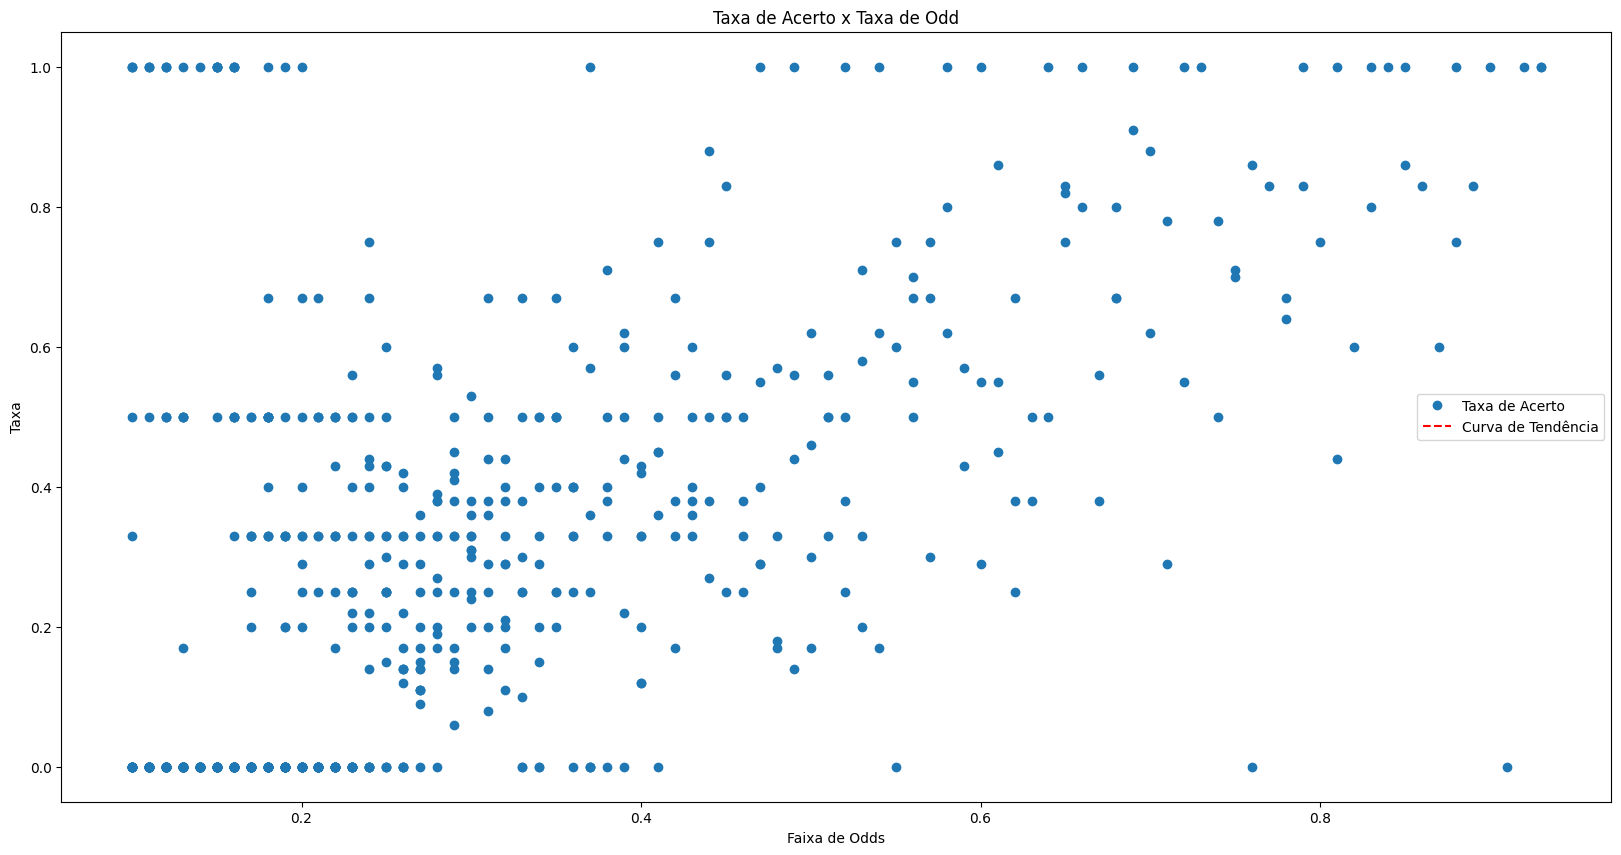

In [41]:
# Agora vamos realizar um plot scatter para visualizar melhor os dados
# Importando as bibliotecas necessárias
import matplotlib.pyplot as plt

# Plotando o gráfico
plt.figure(figsize=(20, 10))
plt.scatter(data.index, data['% Odd'], label='Taxa de Odd')
plt.scatter(data.index, data['% Real'], label='Taxa de Acerto')
plt.xlabel('Faixa de Odds')
plt.ylabel('Taxa')
plt.title('Taxa de Acerto x Taxa de Odd')
plt.legend()
plt.show()
